In [76]:
import librosa
import numpy as np
import os
import pandas as pd
import soundfile
import sys
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

%matplotlib inline

We define a function that takes a set of features per time frame and stack the mean so that the data becomes 1-Dimension.

In [2]:
def feature_to_1d(features):
    result = np.array([])
    mfcc = np.mean(features.T, axis=0)
    result = np.hstack((result, mfcc))
    return result

We import the binary files containing the original features (MFCCs, and Mel-Spectrogram) in 2D form, as well as the labels corresponding to each feature set.

In [78]:
#mel

f = open('IEMOCAP_Data/Data_30_sec/X_train_mel', 'rb')
X_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_test_mel', 'rb')
X_test_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_train_mel', 'rb')
y_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_test_mel', 'rb')
y_test_mel = joblib.load(f)
f.close()

#mfcc

f = open('IEMOCAP_Data/Data_30_sec/X_train_mfcc', 'rb')
X_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_test_mfcc', 'rb')
X_test_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_train_mfcc', 'rb')
y_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/y_test_mfcc', 'rb')
y_test_mfcc = joblib.load(f)
f.close()

## Find the indices of clipped audio (test)

In [79]:
X_test_mfcc.shape

(900, 40, 872)

In [80]:
clipped_indices = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_test_mel[i][j][k] != 0):
                clipped_indices.append(i)

len(clipped_indices)

1600

In [81]:
x_clipped =np.array(clipped_indices)
x_clipped =np.unique(x_clipped)

x_clipped

array([  5,  32,  37,  48,  69,  77,  80,  86, 107, 112, 116, 141, 145,
       154, 168, 172, 204, 210, 231, 236, 330, 351, 372, 417, 419, 464,
       482, 505, 587, 636, 693, 720, 733, 743, 756, 800, 811, 842, 852,
       897])

In [82]:
x_unclipped = []
for i in range(len(X_test_mel)):
    if i not in x_clipped:
        x_unclipped.append(i)
x_unclipped = np.array(x_unclipped)
#x_unclipped

len(x_unclipped)

860

32 + 40 = 72

## Examine clipped audio in train set

In [83]:
clipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                clipped_indices_train.append(i)

x_clipped_t =np.array(clipped_indices_train)
x_clipped_t =np.unique(x_clipped_t)

len(x_clipped_t)

32

In [84]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_clipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_clipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

len(test_labels)

40

In [85]:
from collections import Counter
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({2: 10, 1: 9, 0: 8, 4: 7, 5: 6})


In [86]:
print("Train count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(train_labels.count(0),train_labels.count(1),train_labels.count(2),train_labels.count(3),train_labels.count(4),train_labels.count(5)))

Train count:
Anger: 2
Happy: 3
Sad: 12
Fear: 0
Surprise: 6
Neutral: 9



In [87]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))


Test count:
Anger: 8
Happy: 9
Sad: 10
Fear: 0
Surprise: 7
Neutral: 6



In [88]:
dic_true_val = {}
dic_true_val['ang'] = test_labels.count(0)
dic_true_val['hap'] = test_labels.count(1)
dic_true_val['sad'] = test_labels.count(2)
dic_true_val['fea'] = test_labels.count(3)
dic_true_val['sur'] = test_labels.count(4)
dic_true_val['neu'] = test_labels.count(5)

### Converting to 1D Data

We convert the 2D features to 1D data.

In [98]:
X_train_mel_1d = []
X_test_mel_1d = []
X_train_mfcc_1d = []
X_test_mfcc_1d = []

In [99]:
for i in range(len(X_train_mel)):
    X_train_mel_1d.append(feature_to_1d(X_train_mel[i]))
for i in range(len(X_test_mel)):
    X_test_mel_1d.append(feature_to_1d(X_test_mel[i]))
for i in range(len(X_train_mfcc)):
    X_train_mfcc_1d.append(feature_to_1d(X_train_mfcc[i]))
for i in range(len(X_test_mfcc)):
    X_test_mfcc_1d.append(feature_to_1d(X_test_mfcc[i]))

In [100]:
X_train_mel = np.array(X_train_mel_1d)
X_test_mel = np.array(X_test_mel_1d)
X_train_mfcc = np.array(X_train_mfcc_1d)
X_test_mfcc = np.array(X_test_mfcc_1d)

In [101]:
X_train_mel.shape

(2100, 128)

In [102]:
X_train_mfcc.shape

(2100, 40)

Split data into train and test set per feature.

### Transform the y data 

We transform the y data containing the labels into onehot-encoded form so that the models can classify the categorical accuracy and loss.

In [45]:
y_onehot_train_mel = y_train_mel
y_onehot_test_mel = y_test_mel

y_onehot_train_mfcc = y_train_mfcc
y_onehot_test_mfcc = y_test_mfcc

In [46]:
y_onehot_train_mel = pd.get_dummies(y_onehot_train_mel)
y_onehot_test_mel = pd.get_dummies(y_onehot_test_mel)

y_onehot_train_mfcc = pd.get_dummies(y_onehot_train_mfcc)
y_onehot_test_mfcc = pd.get_dummies(y_onehot_test_mfcc)

In [47]:
y_onehot_train_mel = np.asarray(y_onehot_train_mel).astype('int8')
y_onehot_test_mel  = np.asarray(y_onehot_test_mel).astype('int8')

y_onehot_train_mfcc = np.asarray(y_onehot_train_mfcc).astype('int8')
y_onehot_test_mfcc  = np.asarray(y_onehot_test_mfcc).astype('int8')

Import libraries needed for defining the models.

In [48]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, GlobalMaxPooling1D, Concatenate, BatchNormalization, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

In [74]:
X_train_mfcc.shape

(2100, 40)

Expand the dimensions for the training and testing data so that it can be used for the neural networks.

In [50]:
X_traincnn_mfcc = np.expand_dims(X_train_mfcc, axis = 2)
X_testcnn_mfcc = np.expand_dims(X_test_mfcc, axis = 2)
X_traincnn_mel = np.expand_dims(X_train_mel, axis = 2)
X_testcnn_mel = np.expand_dims(X_test_mel, axis = 2)

#### We define some functions for training and testing

In [51]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [89]:
def print_index(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_index = [] #indices of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_index.append(i)
            
    return correct_instances_index
def print_labels(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_label = [] #labels of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_label.append(y_pred[i])
            
    return correct_instances_label

In [90]:
def count_label(x):
    ang = 0
    hap = 0
    sad = 0
    fea = 0
    sur = 0
    neu = 0
    
    dic = {}
    #my_dict['name']='Nick'
    for i in range(len(x)):
        if(x[i]==0):
            ang += 1
        elif(x[i]==1):
            hap += 1
        elif(x[i]==2):
            sad += 1
        elif(x[i]==3):
            fea += 1
        elif(x[i]==4):
            sur += 1
        elif(x[i]==5):
            neu += 1
    dic['ang'] = ang
    dic['hap'] = hap
    dic['sad'] = sad
    dic['fea'] = fea
    dic['sur'] = sur
    dic['neu'] = neu
    
    return dic

In [52]:
checkpoint_path = 'IEMOCAP_Data/Weights/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

#### MFCC

We use MFCC as input features.

In [103]:
X_train_mfcc_np = np.array(X_train_mfcc)
X_test_mfcc_np = np.array(X_test_mfcc)
y_train_mfcc_np = np.array(y_train_mfcc)
y_test_mfcc_np = np.array(y_test_mfcc)

In [104]:
print(X_train_mfcc_np.shape)
print(X_test_mfcc_np.shape)
print(y_onehot_train_mfcc.shape)
print(y_onehot_test_mfcc.shape)

(2100, 40)
(900, 40)
(2100, 6)
(900, 6)


In [105]:
X_test_mfcc_np.shape

(900, 40)

# Results using Machine Learning algorithms

In this section of the notebook, we perform experiments on the data we have using traditional Machine Learning algorithms. We define a set of functions to visualize the performance of each ML model.

In [56]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    print(num_classes)
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(fbeta_score(y_test, pred, beta= 1.0,average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

## MFCC

In this section, we use MFCCs as input for the ML models.

#### MLP Classifier

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


6
Test Set Accuracy =  0.639
Test Set F-score =  0.628
Test Set Precision =  0.627
Test Set Recall =  0.631
Confusion matrix, without normalization
[[ 74  26   8   0  11  11]
 [ 22  74  20   0  19  18]
 [ 15  12  72   2   8  35]
 [  0   0   0 158   0   0]
 [  2  11   7   0 135  10]
 [  6  29  35   2  16  62]]


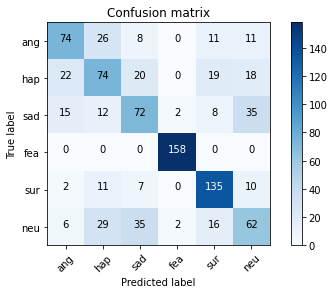

In [67]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='logistic', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.554
Test Set F-score =  0.536
Test Set Precision =  0.614
Test Set Recall =  0.542
Confusion matrix, without normalization
[[ 38  42   0   3  20  27]
 [  5  58   8   2  43  37]
 [  2  18  42   1  25  56]
 [  0   0   0 138   0  20]
 [  0   6   9  10 120  20]
 [  1  13   6   3  24 103]]


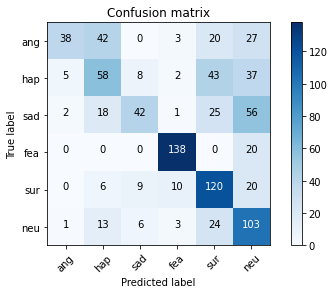

In [69]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

6
Test Set Accuracy =  0.440
Test Set F-score =  0.418
Test Set Precision =  0.513
Test Set Recall =  0.438
Confusion matrix, without normalization
[[ 57   3  13   2  27  28]
 [ 23   5  25   1  60  39]
 [  9   1  74   0  19  41]
 [  0   0  17  75  46  20]
 [  8   0  23   4 106  24]
 [  2   1  42   1  25  79]]


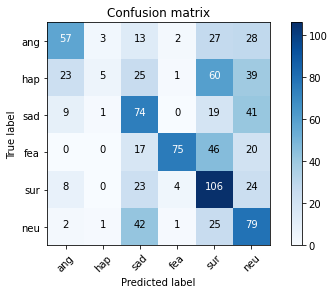

In [116]:
### MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='identity', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs)

In [106]:
### MLP Classifier
mlp_classifier_mfcc = MLPClassifier(hidden_layer_sizes=(500, ), activation='tanh', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.0008,
                               power_t=0.5, max_iter=1000)
mlp_classifier_mfcc.fit(X_train_mfcc, y_train_mfcc)

MLPClassifier(activation='tanh', hidden_layer_sizes=(500,),
              learning_rate_init=0.0008, max_iter=1000)

6
Test Set Accuracy =  0.720
Test Set F-score =  0.703
Test Set Precision =  0.725
Test Set Recall =  0.716
Confusion matrix, without normalization
[[109   5   5   0   2   9]
 [ 35  55  17   0  10  36]
 [ 20   4  68   1   2  49]
 [  0   0   0 158   0   0]
 [  0   0   0   0 158   7]
 [ 10   9  25   1   5 100]]


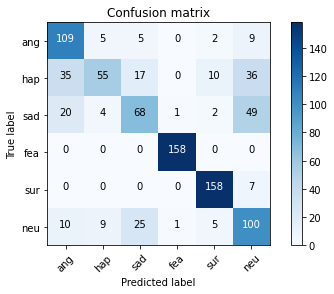

In [107]:
# Predict
pred_probs_mlp_mfcc = mlp_classifier_mfcc.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs_mlp_mfcc)

In [108]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), pred_probs_mlp_mfcc.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.63      0.84      0.72       130
         hap       0.75      0.36      0.49       153
         sad       0.59      0.47      0.53       144
         fea       0.99      1.00      0.99       158
         sur       0.89      0.96      0.92       165
         neu       0.50      0.67      0.57       150

    accuracy                           0.72       900
   macro avg       0.72      0.72      0.70       900
weighted avg       0.73      0.72      0.71       900



# --------------------------------------------------------------------------------

#### Support Vector Machine

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


6
Test Set Accuracy =  0.276
Test Set F-score =  0.206
Test Set Precision =  0.570
Test Set Recall =  0.262
Confusion matrix, without normalization
[[ 33   0   0   1  96   0]
 [  9   1   0   1 141   1]
 [ 10   0   5   0 125   4]
 [  0   0   0  40 118   0]
 [  0   0   0   0 165   0]
 [  3   1   2   0 140   4]]


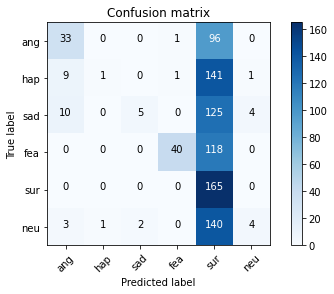

In [127]:
## SVM LINEAR
svc_classifier = LinearSVC()

svc_classifier.fit(X_train_mfcc, y_train_mfcc)

# Predict
pred = svc_classifier.predict(X_test_mfcc)
pred_onehot = np.zeros((pred.size, pred.max()+1))
pred_onehot[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mfcc, pred_onehot)

In [151]:
svc_classifier_mfcc = SVC(kernel='rbf')

svc_classifier_mfcc.fit(X_train_mfcc, y_train_mfcc)

SVC()

6
Test Set Accuracy =  0.219
Test Set F-score =  0.147
Test Set Precision =  0.111
Test Set Recall =  0.230
Confusion matrix, without normalization
[[ 78   0  22  30   0   0]
 [ 73   0  34  46   0   0]
 [ 53   0  44  47   0   0]
 [ 55   0  28  75   0   0]
 [106   0  35  24   0   0]
 [ 46   0  41  63   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


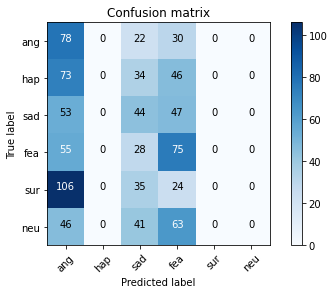

In [152]:
# Predict
pred = svc_classifier_mfcc.predict(X_test_mfcc)
pred_onehot_svc_mfcc = np.zeros((pred.size, pred.max()+1))
pred_onehot_svc_mfcc[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mfcc, pred_onehot_svc_mfcc)

In [153]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), pred_onehot_svc_mfcc.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.19      0.60      0.29       130
         hap       0.00      0.00      0.00       153
         sad       0.22      0.31      0.25       144
         fea       0.26      0.47      0.34       158
         sur       0.00      0.00      0.00       165
         neu       0.00      0.00      0.00       150

    accuracy                           0.22       900
   macro avg       0.11      0.23      0.15       900
weighted avg       0.11      0.22      0.14       900



/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

#### Logistic Regression

In [138]:
lr_classifier_mfcc = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier_mfcc.fit(X_train_mfcc, y_train_mfcc)

LogisticRegression(max_iter=500, multi_class='multinomial', solver='newton-cg')

6
Test Set Accuracy =  0.551
Test Set F-score =  0.537
Test Set Precision =  0.532
Test Set Recall =  0.548
Confusion matrix, without normalization
[[ 77  21   5   3  12  12]
 [ 38  47  14   6  34  14]
 [ 16  12  69   1  15  31]
 [  0   0   0 158   0   0]
 [ 11  14  15  11  91  23]
 [ 16  21  37   5  17  54]]


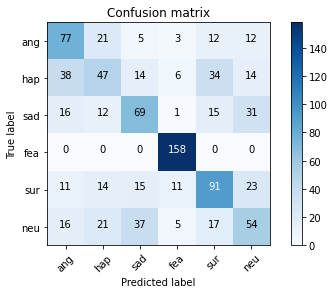

In [139]:
# Predict
pred_probs_lr_mfcc = lr_classifier_mfcc.predict_proba(X_test_mfcc)

# Results
display_results(y_test_mfcc, pred_probs_lr_mfcc)

In [140]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), pred_probs_lr_mfcc.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.49      0.59      0.53       130
         hap       0.41      0.31      0.35       153
         sad       0.49      0.48      0.49       144
         fea       0.86      1.00      0.92       158
         sur       0.54      0.55      0.54       165
         neu       0.40      0.36      0.38       150

    accuracy                           0.55       900
   macro avg       0.53      0.55      0.54       900
weighted avg       0.54      0.55      0.54       900



## MEL

We use Mel-spectrogram as input features.

#### MLP Classifier

In [154]:
### MLP Classifier
mlp_classifier_mel = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                               power_t=0.5, max_iter=1000)

mlp_classifier_mel.fit(X_train_mel, y_train_mel)

MLPClassifier(hidden_layer_sizes=(500,), learning_rate='adaptive',
              max_iter=1000)

6
Test Set Accuracy =  0.656
Test Set F-score =  0.633
Test Set Precision =  0.652
Test Set Recall =  0.652
Confusion matrix, without normalization
[[108   4   4   0   3  11]
 [ 42  43  28   0   6  34]
 [ 21  10  49   1   7  56]
 [  0   0   0 158   0   0]
 [ 19   0   0   0 146   0]
 [ 14  10  30   1   9  86]]


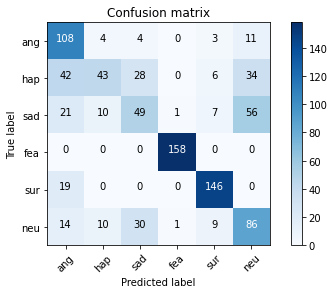

In [155]:
# Predict
pred_probs_mlp_mel = mlp_classifier_mel.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs_mlp_mel)

In [156]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), pred_probs_mlp_mel.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.53      0.83      0.65       130
         hap       0.64      0.28      0.39       153
         sad       0.44      0.34      0.38       144
         fea       0.99      1.00      0.99       158
         sur       0.85      0.88      0.87       165
         neu       0.46      0.57      0.51       150

    accuracy                           0.66       900
   macro avg       0.65      0.65      0.63       900
weighted avg       0.66      0.66      0.64       900



#### Support Vector Machines

In [168]:
## SVM NON-LINEAR
svc_classifier_mel = SVC(kernel = 'rbf')

svc_classifier_mel.fit(X_train_mel, y_train_mel)

SVC()

6
Test Set Accuracy =  0.577
Test Set F-score =  0.572
Test Set Precision =  0.584
Test Set Recall =  0.571
Confusion matrix, without normalization
[[ 71  33  11   3   3   9]
 [ 30  69  19   3   5  27]
 [ 15  34  58   2   8  27]
 [  0   0   0 158   0   0]
 [ 15  27  16   4 101   2]
 [ 14  36  32   2   4  62]]


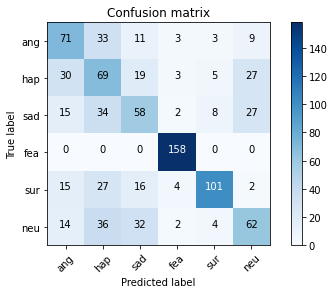

In [169]:
# Predict
pred = svc_classifier_mel.predict(X_test_mel)
pred_onehot_svc_mel = np.zeros((pred.size, pred.max()+1))
pred_onehot_svc_mel[np.arange(pred.size),pred] = 1

# Results
display_results(y_test_mel, pred_onehot_svc_mel)

In [170]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), pred_onehot_svc_mel.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.49      0.55      0.52       130
         hap       0.35      0.45      0.39       153
         sad       0.43      0.40      0.41       144
         fea       0.92      1.00      0.96       158
         sur       0.83      0.61      0.71       165
         neu       0.49      0.41      0.45       150

    accuracy                           0.58       900
   macro avg       0.58      0.57      0.57       900
weighted avg       0.59      0.58      0.58       900



#### Logistic Regression 

In [180]:
lr_classifier_mel = LogisticRegression(solver='newton-cg', multi_class='multinomial', max_iter=500)

lr_classifier_mel.fit(X_train_mel, y_train_mel)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(max_iter=500, multi_class='multinomial', solver='newton-cg')

6
Test Set Accuracy =  0.600
Test Set F-score =  0.582
Test Set Precision =  0.577
Test Set Recall =  0.592
Confusion matrix, without normalization
[[ 78  21  10   0  11  10]
 [ 28  58  23   4  12  28]
 [ 21  18  48   4  14  39]
 [  0   0   0 158   0   0]
 [  8  10   3   0 135   9]
 [  9  17  36   3  22  63]]


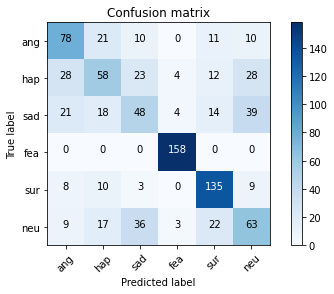

In [181]:
# Predict
pred_probs_lr_mel = lr_classifier_mel.predict_proba(X_test_mel)

# Results
display_results(y_test_mel, pred_probs_lr_mel)

In [182]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), pred_probs_lr_mel.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.54      0.60      0.57       130
         hap       0.47      0.38      0.42       153
         sad       0.40      0.33      0.36       144
         fea       0.93      1.00      0.97       158
         sur       0.70      0.82      0.75       165
         neu       0.42      0.42      0.42       150

    accuracy                           0.60       900
   macro avg       0.58      0.59      0.58       900
weighted avg       0.58      0.60      0.59       900

